In [1]:
import polars as pl

import rustystats as rs

import matplotlib.pyplot as plt
import numpy as np

data = pl.read_parquet("https://raw.githubusercontent.com/PricingFrontier/pricing-data-example/917c853e256df8d5814721ab56f72889a908bb08/data/processed/frequency_set.parquet")

In [2]:
data.columns

['IDpol',
 'VehPower',
 'VehAge',
 'DrivAge',
 'BonusMalus',
 'VehBrand',
 'VehGas',
 'Area',
 'Density',
 'Region',
 'Group',
 'Exposure',
 'ClaimCount']

In [3]:
exploration = rs.explore_data(
    data=data,
    response="ClaimCount",
    categorical_factors=["Region", "Area", "VehBrand", "VehGas", "Region"],
    continuous_factors=["VehPower", "VehAge", "DrivAge", "BonusMalus" ],
    exposure="Exposure",
)

In [4]:
exploration.to_json()

'{"data_summary": {"n_rows": 678012, "n_columns": 13, "response_column": "ClaimCount", "exposure_column": "Exposure", "n_categorical_factors": 4, "n_continuous_factors": 4}, "factor_stats": [{"name": "VehPower", "type": "continuous", "mean": 6.4546, "std": 2.0509, "min": 4.0, "max": 15.0, "missing_count": 0, "missing_pct": 0.0, "response_by_bin": [{"bin_index": 1, "bin_lower": 4.0, "bin_upper": 5.0, "count": 115349, "exposure": 60073.64, "response_sum": 5605.0, "response_rate": 0.093302}, {"bin_index": 3, "bin_lower": 5.0, "bin_upper": 6.0, "count": 124821, "exposure": 68173.35, "response_sum": 7159.0, "response_rate": 0.105012}, {"bin_index": 5, "bin_lower": 6.0, "bin_upper": 7.0, "count": 148976, "exposure": 82524.21, "response_sum": 8260.0, "response_rate": 0.100092}, {"bin_index": 7, "bin_lower": 7.0, "bin_upper": 8.0, "count": 145400, "exposure": 77949.54, "response_sum": 7503.0, "response_rate": 0.096255}, {"bin_index": 8, "bin_lower": 8.0, "bin_upper": 9.0, "count": 46956, "expo

In [5]:
data = data.with_columns([
    pl.col("Density").log().alias("log_Density"),
    pl.col("BonusMalus").log().alias("log_BonusMalus"),
])

formula = """
    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)
"""

model = rs.glm(
    formula=formula,
    data=data,
    family="poisson",
    offset="Exposure"
).fit(alpha=0.5, l1_ratio=0.5)

In [6]:
print(model.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677994
Method:              IRLS + Elasticnet Df Model:                    17
Scale:               1.0000          Alpha (λ):               0.5000
L1 Ratio:            0.50            Iterations:                  25
Non-zero coefs:      17             

Log-Likelihood:         -140775.8534 Deviance:                212551.5606
AIC:                     281587.7067 Null Deviance:           214041.4441
BIC:                     281793.3913 Pearson chi2:         10121204239.34
Converged:           False          

------------------------------------------------------------------------------
Variable                  Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept              -3.153

In [7]:
diagnostics = model.diagnostics(
    data,
    categorical_factors=["Region", "Area", "VehBrand", "VehGas"],
    continuous_factors=["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
)

In [8]:
# Predict on the data
predictions = model.predict(data, offset="Exposure")
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim rate: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

Predictions shape: (678012,)
Mean predicted claim rate: 0.052403
Min: 0.000000, Max: 1.304357


In [9]:
def plot_ae_chart(
    data: pl.DataFrame,
    factor: str,
    bins: list = None,
    use_rate: bool = False,
    figsize: tuple = (12, 4),
    title: str = None,
):
    """
    Plot Actual vs Expected chart with exposure bars and A/E ratio.
    
    Parameters
    ----------
    data : pl.DataFrame
        Data with 'Actual', 'Predicted', and 'Exposure' columns.
    factor : str
        Column name to group by.
    bins : list, optional
        For continuous factors, bin edges. If None, treats factor as categorical.
    use_rate : bool
        If True, plot rates (per exposure) instead of counts.
    figsize : tuple
        Figure size.
    title : str, optional
        Custom title. Defaults to factor name.
    """
    # Bin continuous factors if bins provided
    if bins is not None:
        bin_col = f"{factor}_bin"
        grouped = data.with_columns([
            pl.col(factor).cut(bins).alias(bin_col)
        ]).group_by(bin_col).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ])
        
        # Create proper sort order based on bin edges (not alphabetical)
        bin_labels = grouped[bin_col].to_list()
        # Extract the lower bound from each bin label for sorting
        def get_bin_lower(label):
            if label is None:
                return float('inf')
            s = str(label)
            # Handle formats like "(0, 2]" or "(-inf, 0]"
            try:
                lower = s.split(',')[0].strip('([')
                if lower == '-inf':
                    return float('-inf')
                return float(lower)
            except:
                return float('inf')
        
        sort_order = sorted(range(len(bin_labels)), key=lambda i: get_bin_lower(bin_labels[i]))
        grouped = grouped[sort_order]
        labels = [str(b) for b in grouped[bin_col].to_list()]
    else:
        grouped = data.group_by(factor).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ]).sort(factor)
        labels = [str(v) for v in grouped[factor].to_list()]
    
    # Calculate A/E and rates
    grouped = grouped.with_columns([
        (pl.col("Actual") / pl.col("Expected")).alias("A/E"),
        (pl.col("Actual") / pl.col("Exposure")).alias("Actual_Rate"),
        (pl.col("Expected") / pl.col("Exposure")).alias("Expected_Rate")
    ])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    x = np.arange(len(labels))
    
    # Left: Exposure bar with Actual/Expected lines
    ax1 = axes[0]
    ax2 = ax1.twinx()
    
    ax1.bar(x, grouped["Exposure"].to_numpy(), alpha=0.3, color="gray", label="Exposure")
    ax1.set_ylabel("Exposure", color="gray")
    ax1.tick_params(axis="y", labelcolor="gray")
    ax1.set_ylim(bottom=0)
    
    if use_rate:
        y_actual = grouped["Actual_Rate"].to_numpy()
        y_expected = grouped["Expected_Rate"].to_numpy()
        y_label = "Claim Rate"
    else:
        y_actual = grouped["Actual"].to_numpy()
        y_expected = grouped["Expected"].to_numpy()
        y_label = "Claim Count"
    
    ax2.plot(x, y_actual, "o-", color="steelblue", linewidth=2, markersize=8, label="Actual")
    ax2.plot(x, y_expected, "s--", color="coral", linewidth=2, markersize=8, label="Expected")
    ax2.set_ylabel(y_label, color="black")
    ax2.set_ylim(bottom=0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    ax1.set_xlabel(title or factor)
    ax1.set_title(f"Actual vs Expected by {title or factor}")
    ax2.legend(loc="upper left")
    
    # Right: A/E ratio
    ae_vals = grouped["A/E"].to_numpy()
    colors = ["green" if 0.95 <= v <= 1.05 else "orange" if 0.9 <= v <= 1.1 else "teal" for v in ae_vals]
    axes[1].bar(labels, ae_vals, color=colors)
    axes[1].axhline(y=1.0, color="red", linestyle="--", label="Perfect calibration")
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    axes[1].set_xlabel(title or factor)
    axes[1].set_ylabel("A/E Ratio")
    axes[1].set_title(f"A/E Ratio by {title or factor}")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return grouped

In [10]:
print(formula)


    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)



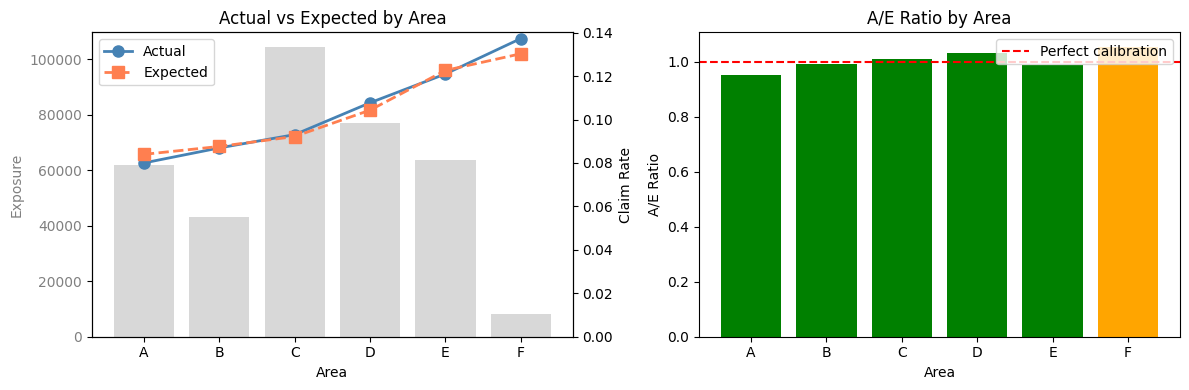

Area,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""A""",4958,5203.136056,61969.377712,0.952887,0.080007,0.083963
"""B""",3739,3768.293938,43012.323931,0.992226,0.086929,0.08761
"""C""",9719,9628.617309,104449.003785,1.009387,0.09305,0.092185
"""D""",8307,8045.336156,77119.271692,1.032524,0.107716,0.104323
"""E""",7721,7825.070852,63819.31427,0.9867,0.120982,0.122613
"""F""",1116,1059.086304,8129.234074,1.053738,0.137282,0.130281


In [11]:
plot_ae_chart(plot_data, "Area", use_rate=True)

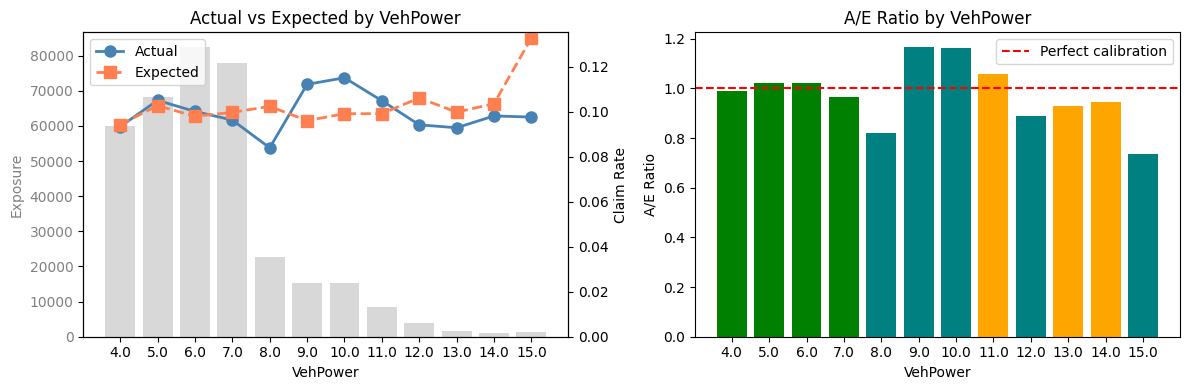

VehPower,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
f64,i32,f64,f64,f64,f64,f64
4.0,5605,5660.706774,60073.637304,0.990159,0.093302,0.094229
5.0,7159,6997.440089,68173.348821,1.023088,0.105012,0.102642
6.0,8260,8084.572375,82524.210172,1.021699,0.100092,0.097966
7.0,7503,7770.555653,77949.5367,0.965568,0.096255,0.099687
8.0,1904,2321.437015,22684.616305,0.820182,0.083934,0.102335
…,…,…,…,…,…,…
11.0,891,842.169335,8497.778452,1.057982,0.104851,0.099105
12.0,357,402.299245,3792.038343,0.887399,0.094145,0.106091
13.0,152,163.328708,1637.255322,0.930639,0.092838,0.099758


In [12]:
plot_ae_chart(plot_data, "VehPower", use_rate=True)

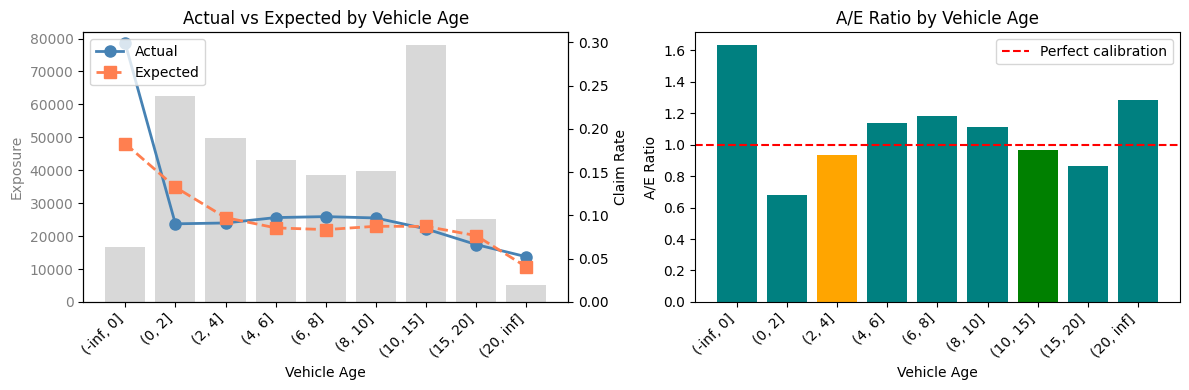

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3059.064998,16719.028729,1.633179,0.298821,0.182969
"""(0, 2]""",5641,8285.764789,62457.026619,0.680806,0.090318,0.132663
"""(2, 4]""",4550,4861.435666,49841.358576,0.935938,0.09129,0.097538
"""(4, 6]""",4193,3680.822847,42987.678107,1.139147,0.09754,0.085625
"""(6, 8]""",3797,3218.752669,38486.488979,1.17965,0.098658,0.083633
"""(8, 10]""",3858,3475.762648,39732.594475,1.109972,0.097099,0.087479
"""(10, 15]""",6588,6811.125027,77990.975407,0.967241,0.084471,0.087332
"""(15, 20]""",1668,1927.893962,25136.158607,0.865193,0.066359,0.076698
"""(20, inf]""",269,208.918011,5147.215965,1.287586,0.052261,0.040589


In [13]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

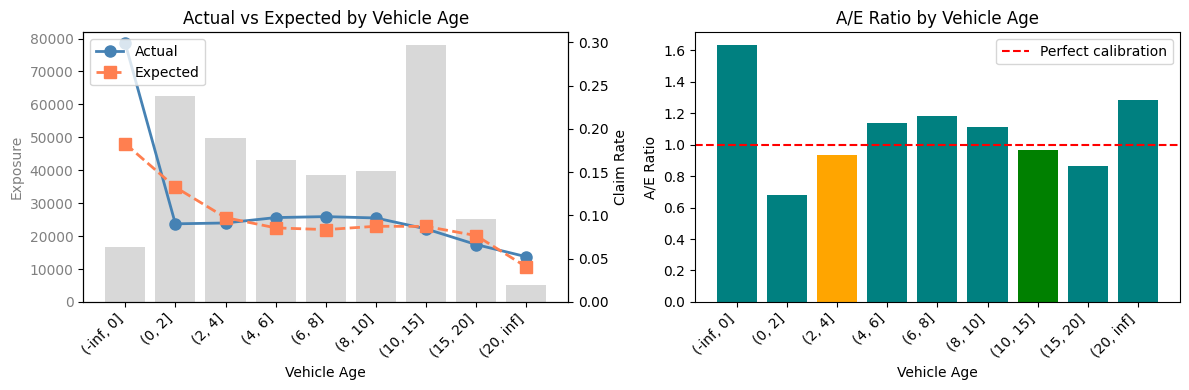

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,3059.064998,16719.028729,1.633179,0.298821,0.182969
"""(0, 2]""",5641,8285.764789,62457.026619,0.680806,0.090318,0.132663
"""(2, 4]""",4550,4861.435666,49841.358576,0.935938,0.09129,0.097538
"""(4, 6]""",4193,3680.822847,42987.678107,1.139147,0.09754,0.085625
"""(6, 8]""",3797,3218.752669,38486.488979,1.17965,0.098658,0.083633
"""(8, 10]""",3858,3475.762648,39732.594475,1.109972,0.097099,0.087479
"""(10, 15]""",6588,6811.125027,77990.975407,0.967241,0.084471,0.087332
"""(15, 20]""",1668,1927.893962,25136.158607,0.865193,0.066359,0.076698
"""(20, inf]""",269,208.918011,5147.215965,1.287586,0.052261,0.040589


In [14]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

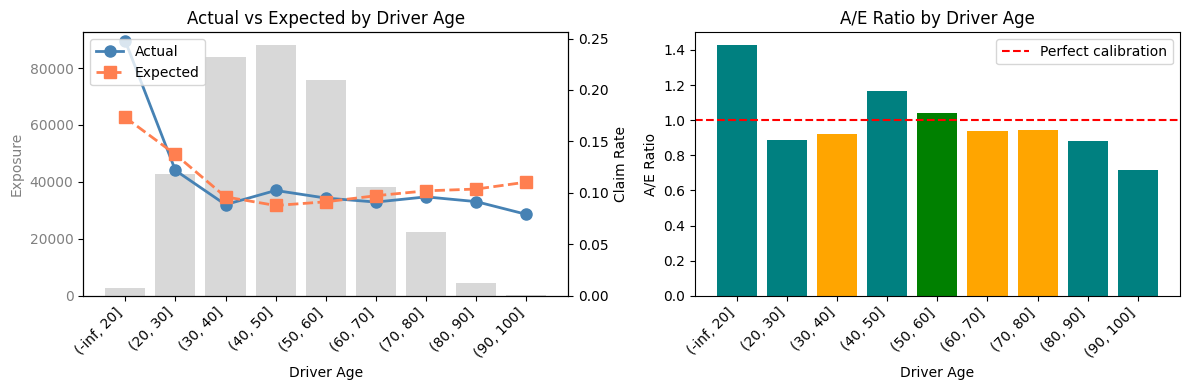

DrivAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 20]""",640,447.970683,2584.582839,1.428665,0.247622,0.173324
"""(20, 30]""",5218,5881.312467,42822.634243,0.887217,0.121851,0.137341
"""(30, 40]""",7435,8064.380467,83937.299011,0.921956,0.088578,0.096076
"""(40, 50]""",9021,7734.11828,88138.310203,1.16639,0.10235,0.08775
"""(50, 60]""",7190,6915.235382,75727.63601,1.039733,0.094946,0.091317
"""(60, 70]""",3491,3727.431277,38332.688531,0.93657,0.091071,0.097239
"""(70, 80]""",2138,2268.580501,22246.083144,0.94244,0.096107,0.101977
"""(80, 90]""",402,455.617124,4393.353277,0.88232,0.091502,0.103706
"""(90, 100]""",25,34.894434,315.938204,0.716447,0.079129,0.110447


In [15]:
plot_ae_chart(plot_data, "DrivAge", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Driver Age")

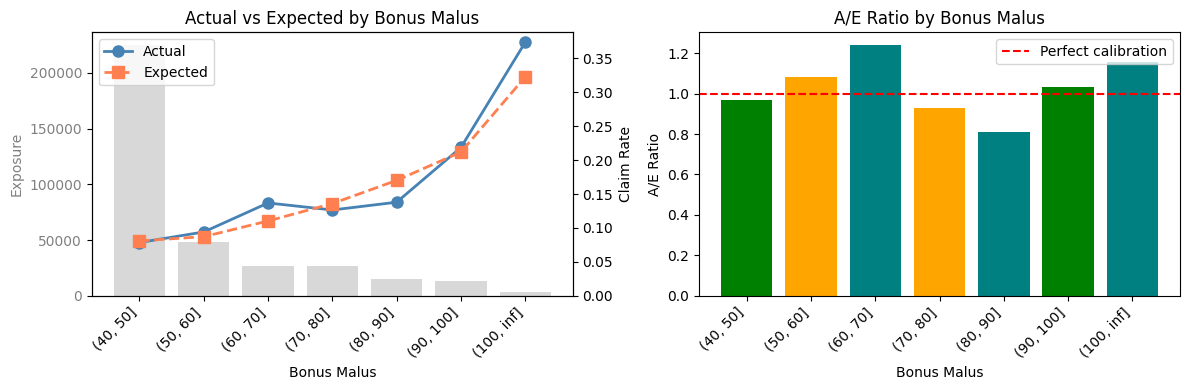

BonusMalus_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(40, 50]""",17688,18227.502304,225233.130902,0.970402,0.078532,0.080927
"""(50, 60]""",4515,4180.818202,47985.497013,1.079932,0.094091,0.087127
"""(60, 70]""",3627,2922.930587,26497.713499,1.240878,0.13688,0.110309
"""(70, 80]""",3361,3611.826074,26567.633294,0.930554,0.126507,0.135948
"""(80, 90]""",2104,2594.591794,15246.839478,0.810918,0.137996,0.170172
"""(90, 100]""",2930,2838.998752,13396.392272,1.032054,0.218716,0.211923
"""(100, inf]""",1335,1152.872901,3571.319003,1.157977,0.373811,0.322814


In [16]:
plot_ae_chart(plot_data, "BonusMalus", bins=[20,30,40,50,60,70,80,90,100], use_rate=True, title="Bonus Malus")

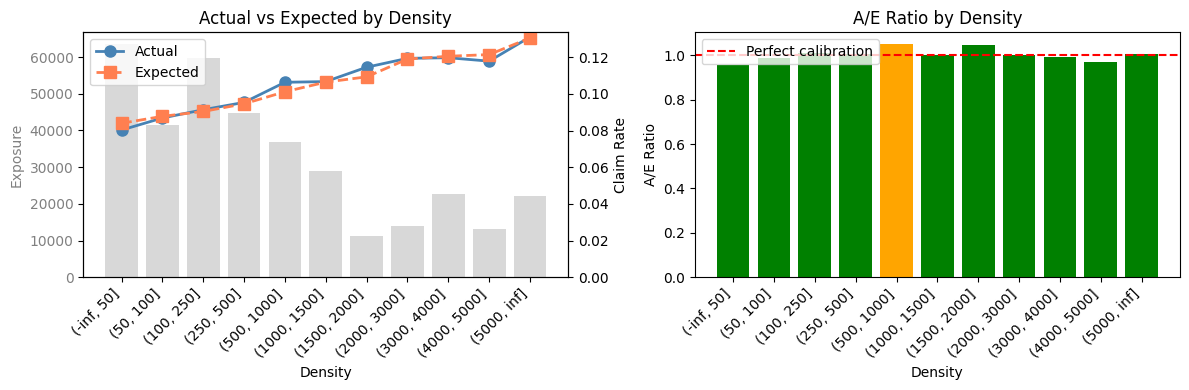

Density_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 50]""",5104,5338.785669,63584.203398,0.956023,0.080272,0.083964
"""(50, 100]""",3603,3640.477531,41483.182857,0.989705,0.086854,0.087758
"""(100, 250]""",5460,5402.443149,59766.263508,1.010654,0.091356,0.090393
"""(250, 500]""",4257,4222.955978,44644.931144,1.008062,0.095352,0.09459
"""(500, 1000]""",3912,3721.960627,36793.095132,1.051059,0.106324,0.101159
…,…,…,…,…,…,…
"""(1500, 2000]""",1299,1239.435762,11340.499495,1.048058,0.114545,0.109293
"""(2000, 3000]""",1678,1672.544758,14054.663173,1.003262,0.119391,0.119003
"""(3000, 4000]""",2706,2723.946734,22601.158855,0.993411,0.119728,0.120522


In [17]:
plot_ae_chart(plot_data, "Density", bins=[50, 100, 250, 500, 1000, 1500, 2000,3000,4000,5000], use_rate=True, title="Density")